In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# preprocessing
import re
import string
import itertools # for flattening
# nltk library
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer as wn
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
nltk.download('punkt', quiet=True)
nltk.download('stopwords')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
# sklearn library
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to /Users/Shen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/Shen/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Shen/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/Shen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#import csv - glassdoor review for citi bank
data=pd.read_csv('FinalGlassdoorReview.csv')
data.head(5)

,Title,Date,Rating,Pros,Cons
0,great experience at citi !,"May 8, 2022 -",5.0,great place to work and learn!,tough deadlines at times !!
1,Solid employer,"Dec 11, 2022 - Vice President",5.0,"Great people, collaboration through department...","Large company, difficult to affect change mean..."
2,Branch Experience,"Jan 5, 2023 - Personal Banker",4.0,Genuinely a good company to work for. Best pay...,Constant system issues. Old technology. Compan...
3,Could be a fantastic company to work for....,"Jan 16, 2023 - Bankruptcy Specialist 3",4.0,Great pay and benefits for entry-level Most ma...,Raises were low. Quite a few managers and lead...
4,Great Company,"Jan 19, 2023 - Senior Trainer - Learning & Dev...",4.0,"It's always the people that you work with, you...",Salary transparency for employees who have bee...


In [3]:
#Separate date to two columns - data and title
data['job_title']=data['Date'].str.split('-', 1).str[1]

In [4]:
data['date']=data['Date'].str.split('-', 1).str[0]

In [5]:
data=data.rename(columns={'Date':'date_job'})

In [6]:
data.head()

,Title,date_job,Rating,Pros,Cons,job_title,date
0,great experience at citi !,"May 8, 2022 -",5.0,great place to work and learn!,tough deadlines at times !!,,"May 8, 2022"
1,Solid employer,"Dec 11, 2022 - Vice President",5.0,"Great people, collaboration through department...","Large company, difficult to affect change mean...",Vice President,"Dec 11, 2022"
2,Branch Experience,"Jan 5, 2023 - Personal Banker",4.0,Genuinely a good company to work for. Best pay...,Constant system issues. Old technology. Compan...,Personal Banker,"Jan 5, 2023"
3,Could be a fantastic company to work for....,"Jan 16, 2023 - Bankruptcy Specialist 3",4.0,Great pay and benefits for entry-level Most ma...,Raises were low. Quite a few managers and lead...,Bankruptcy Specialist 3,"Jan 16, 2023"
4,Great Company,"Jan 19, 2023 - Senior Trainer - Learning & Dev...",4.0,"It's always the people that you work with, you...",Salary transparency for employees who have bee...,Senior Trainer - Learning & Development,"Jan 19, 2023"


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25890 entries, 0 to 25889
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      25773 non-null  object 
 1   date_job   25890 non-null  object 
 2   Rating     25890 non-null  float64
 3   Pros       25890 non-null  object 
 4   Cons       25890 non-null  object 
 5   job_title  25890 non-null  object 
 6   date       25890 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.4+ MB


In [8]:
data.isnull().sum()

Title        117
date_job       0
Rating         0
Pros           0
Cons           0
job_title      0
date           0
dtype: int64

In [9]:
data=data.dropna()

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25773 entries, 0 to 25889
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Title      25773 non-null  object 
 1   date_job   25773 non-null  object 
 2   Rating     25773 non-null  float64
 3   Pros       25773 non-null  object 
 4   Cons       25773 non-null  object 
 5   job_title  25773 non-null  object 
 6   date       25773 non-null  object 
dtypes: float64(1), object(6)
memory usage: 1.6+ MB


In [11]:
data['date']=pd.to_datetime(data['date'])

In [12]:
#Remove special characters
from nltk.stem import PorterStemmer
tokenizer = RegexpTokenizer("([a-zA-Z]+(?:'[a-z]+)?)")
stopwords_list = stopwords.words('english')
otherstopwords=['citi,great,good,company,bank,citibank']
stemmer = PorterStemmer()

In [13]:
#set up define function for tokenize Title Pro and Cons
def preprocess_text(text, tokenizer, stopwords_list, stemmer):
    # Standardize case (lowercase the text)
    text_lower=text.lower()
    # Tokenize text using `tokenizer`
    text_tokenizer=tokenizer.tokenize(text_lower)
    # Remove stopwords using `stopwords_list`
    text_stop_words=[word for word in text_tokenizer if word not in stopwords_list]
    # Stem the tokenized text using `stemmer`
    stemmer=[stemmer.stem(text) for text in text_stop_words]
    # Return the preprocessed text
    return stemmer
preprocess_text("This is an example sentence for preprocessing.", tokenizer, stopwords_list, stemmer)

['exampl', 'sentenc', 'preprocess']

In [14]:
#convert title, pros, cons to tokenized items
convobj=['Title','Pros','Cons']

text=[data[f].apply(lambda x : preprocess_text(x,tokenizer,stopwords_list,stemmer)) for f in convobj]

In [15]:
process_data=pd.DataFrame(data=text)

In [16]:
process_data=process_data.transpose()

In [17]:
process_data=process_data.rename(columns=({'Title':'txtTitle','Pros':'txtPros','Cons':'txtCons'}))

In [18]:
process_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25773 entries, 0 to 25889
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   txtTitle  25773 non-null  object
 1   txtPros   25773 non-null  object
 2   txtCons   25773 non-null  object
dtypes: object(3)
memory usage: 1.8+ MB


In [19]:
process_data.head()

,txtTitle,txtPros,txtCons
0,"[great, experi, citi]","[great, place, work, learn]","[tough, deadlin, time]"
1,"[solid, employ]","[great, peopl, collabor, depart, except]","[larg, compani, difficult, affect, chang, mean..."
2,"[branch, experi]","[genuin, good, compani, work, best, pay, indus...","[constant, system, issu, old, technolog, compa..."
3,"[could, fantast, compani, work]","[great, pay, benefit, entri, level, manag, awe...","[rais, low, quit, manag, lead, rude, thought, ..."
4,"[great, compani]","[alway, peopl, work, peer, make, go, work, bet...","[salari, transpar, employe, role, prior, pay, ..."


In [20]:
new_df=pd.concat([data,process_data],axis=1)

In [21]:
new_df.head()

,Title,date_job,Rating,Pros,Cons,job_title,date,txtTitle,txtPros,txtCons
0,great experience at citi !,"May 8, 2022 -",5.0,great place to work and learn!,tough deadlines at times !!,,2022-05-08,"[great, experi, citi]","[great, place, work, learn]","[tough, deadlin, time]"
1,Solid employer,"Dec 11, 2022 - Vice President",5.0,"Great people, collaboration through department...","Large company, difficult to affect change mean...",Vice President,2022-12-11,"[solid, employ]","[great, peopl, collabor, depart, except]","[larg, compani, difficult, affect, chang, mean..."
2,Branch Experience,"Jan 5, 2023 - Personal Banker",4.0,Genuinely a good company to work for. Best pay...,Constant system issues. Old technology. Compan...,Personal Banker,2023-01-05,"[branch, experi]","[genuin, good, compani, work, best, pay, indus...","[constant, system, issu, old, technolog, compa..."
3,Could be a fantastic company to work for....,"Jan 16, 2023 - Bankruptcy Specialist 3",4.0,Great pay and benefits for entry-level Most ma...,Raises were low. Quite a few managers and lead...,Bankruptcy Specialist 3,2023-01-16,"[could, fantast, compani, work]","[great, pay, benefit, entri, level, manag, awe...","[rais, low, quit, manag, lead, rude, thought, ..."
4,Great Company,"Jan 19, 2023 - Senior Trainer - Learning & Dev...",4.0,"It's always the people that you work with, you...",Salary transparency for employees who have bee...,Senior Trainer - Learning & Development,2023-01-19,"[great, compani]","[alway, peopl, work, peer, make, go, work, bet...","[salari, transpar, employe, role, prior, pay, ..."


In [22]:
new_df['Year']=pd.DatetimeIndex(new_df['date']).year

In [23]:
# takes in untokenized document and returns fully normalized token list
from nltk import WordNetLemmatizer # lemmatizer using WordNet
from nltk.corpus import wordnet # imports WordNet


def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

In [24]:
title_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(new_df['txtTitle'][1]))) 
print(title_tagged)

[('solid', 'a'), ('employ', 'n')]


In [25]:
wnl=WordNetLemmatizer()
doc_lemmatized=[wnl.lemmatize(token,pos)for token,pos in title_tagged if pos is not None]
print(doc_lemmatized)

['solid', 'employ']


In [26]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set up figure and axes
# fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# # Empty dict to hold words that have already been plotted and their colors
# plotted_words_and_colors = {}
# # Establish color palette to pull from
# # (If you get an error message about popping from an empty list, increase this #)
# color_palette = sns.color_palette('cividis', n_colors=38)

# # Creating a plot for each year
# data_by_year = [y for _,y in new_df.groupby('Year', sort=True, as_index=False)]

# for idx, year_df in enumerate(data_by_year):
#     # Find top 10 words in this year
#     all_words_in_year = year_df.txtTitle.explode()
#     top_10 = all_words_in_year.value_counts()[:10]
    
#     # Select appropriate colors, reusing colors if words repeat
#     colors = []
#     for word in top_10.index:
#         if word not in plotted_words_and_colors:
#             new_color = color_palette.pop(0)
#             plotted_words_and_colors[word] = new_color
#         colors.append(plotted_words_and_colors[word])
    
#     # Select axes, plot data, set title
#     ax = axes[idx]
#     ax.bar(top_10.index, top_10.values, color=colors)
#     ax.set_title(year_df.iloc[0].Year)
    
# fig.tight_layout()

In [27]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_text(text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    txt_lower = text.lower()

    #remove mentions, hashtags, and urls, strip whitspace and breaks
    txt_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", txt_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    txt_norm = [x for x in word_tokenize(txt_lower) if ((x.isalpha()) & (x not in stop_words)) & (x not in ['good','great','found','irish','company','lot'])]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    txt_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(txt_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(txt_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        txt_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in txt_tagged if x[1] is not None])
        return txt_norm


In [28]:
new_df.head()

,Title,date_job,Rating,Pros,Cons,job_title,date,txtTitle,txtPros,txtCons,Year
0,great experience at citi !,"May 8, 2022 -",5.0,great place to work and learn!,tough deadlines at times !!,,2022-05-08,"[great, experi, citi]","[great, place, work, learn]","[tough, deadlin, time]",2022
1,Solid employer,"Dec 11, 2022 - Vice President",5.0,"Great people, collaboration through department...","Large company, difficult to affect change mean...",Vice President,2022-12-11,"[solid, employ]","[great, peopl, collabor, depart, except]","[larg, compani, difficult, affect, chang, mean...",2022
2,Branch Experience,"Jan 5, 2023 - Personal Banker",4.0,Genuinely a good company to work for. Best pay...,Constant system issues. Old technology. Compan...,Personal Banker,2023-01-05,"[branch, experi]","[genuin, good, compani, work, best, pay, indus...","[constant, system, issu, old, technolog, compa...",2023
3,Could be a fantastic company to work for....,"Jan 16, 2023 - Bankruptcy Specialist 3",4.0,Great pay and benefits for entry-level Most ma...,Raises were low. Quite a few managers and lead...,Bankruptcy Specialist 3,2023-01-16,"[could, fantast, compani, work]","[great, pay, benefit, entri, level, manag, awe...","[rais, low, quit, manag, lead, rude, thought, ...",2023
4,Great Company,"Jan 19, 2023 - Senior Trainer - Learning & Dev...",4.0,"It's always the people that you work with, you...",Salary transparency for employees who have bee...,Senior Trainer - Learning & Development,2023-01-19,"[great, compani]","[alway, peopl, work, peer, make, go, work, bet...","[salari, transpar, employe, role, prior, pay, ...",2023


In [29]:
new_df['Pros'] = new_df['Pros'].apply(process_text, args = [4])
new_df['Cons'] = new_df['Cons'].apply(process_text, args = [4])
new_df['Title'] = new_df['Title'].apply(process_text, args = [4])

In [30]:
process_text_pros = new_df[new_df['Pros'] != '']
process_text_cons =new_df[new_df['Cons'] != '']
process_text_title=new_df[new_df['Title'] != '']

In [31]:
year_df=new_df[['txtTitle','txtPros','txtCons','Year']].dropna()

In [32]:
year_df=year_df.sort_values(by='Year')

IndexError: index 2008 is out of bounds for axis 0 with size 10

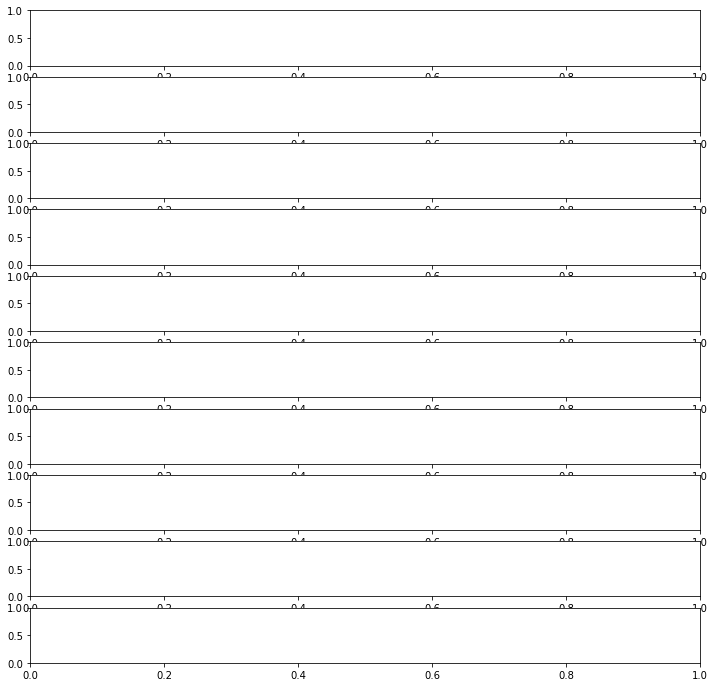

In [33]:
# Set up figure and axes
fig, axes = plt.subplots(nrows=10, figsize=(12, 12))

# Empty dict to hold words that have already been plotted and their colors
plotted_words_and_colors = {}
# Establish color palette to pull from
# (If you get an error message about popping from an empty list, increase this #)
color_palette = sns.color_palette('cividis', n_colors=38)

# Creating a plot for each year
#data_by_year = [y for _,y in new_df.groupby('Year', sort=True, as_index=False)]

years=[x for x in (year_df['Year'].unique())]

all_words_in_year=[]

for year in years:
    # Find top 10 words in this year
    for text in year_df.loc[year_df['Year'] == year]:
        all_words_in_year=year_df['txtPros'].explode()
        top_10 = all_words_in_year.value_counts()[:10]
    # Select appropriate colors, reusing colors if words repeat
        colors = []
        for word in top_10.index:
            if word not in plotted_words_and_colors:
                new_color = color_palette.pop(0)
                plotted_words_and_colors[word] = new_color
            colors.append(plotted_words_and_colors[word])
    
    # Select axes, plot data, set title
    ax = axes[year]
    ax.bar(top_10.index, top_10.values, color=colors)
    ax.set_title(year_df.iloc[0].Year)
    

fig.tight_layout()

## Feature Construction - Pros


In [34]:
# feature construction - Pros
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = new_df['Pros']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)
X_train

<25773x7160 sparse matrix of type '<class 'numpy.float64'>'
	with 129973 stored elements in Compressed Sparse Row format>

In [35]:
len(vectorizer.get_feature_names())

7160

In [36]:
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

topic_model = NMF(n_components = 5)
topic_model.fit(X_train)

NMF(n_components=5)

In [37]:
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (5, 7160)
Shape of H is (25773, 5)
Shape of X_train is (25773, 7160)


In [38]:
for index,topic in enumerate(W):
    print(f'THE TOP 25 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 25 WORDS FOR TOPIC #0
['leaf', 'support', 'stability', 'much', 'policy', 'salary', 'quality', 'value', 'technology', 'personal', 'diversity', 'team', 'compensation', 'decent', 'best', 'growth', 'excellent', 'mobility', 'remote', 'flexibility', 'management', 'culture', 'work', 'life', 'balance']


THE TOP 25 WORDS FOR TOPIC #1
['organization', 'culture', 'new', 'diversity', 'job', 'brand', 'development', 'business', 'citi', 'experience', 'different', 'internal', 'move', 'exposure', 'large', 'grow', 'bank', 'mobility', 'lot', 'many', 'growth', 'career', 'learn', 'global', 'opportunity']


THE TOP 25 WORDS FOR TOPIC #2
['match', 'care', 'bonus', 'excellent', 'package', 'location', 'medical', 'management', 'job', 'holiday', 'flexibility', 'leave', 'well', 'hour', 'insurance', 'day', 'health', 'employee', 'competitive', 'vacation', 'decent', 'salary', 'time', 'pay', 'benefit']


THE TOP 25 WORDS FOR TOPIC #3
['experience', 'salary', 'hard', 'working', 'excellent', 'get', 'manager', 

In [39]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 15
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Top Five Topics in Employee Reviews")

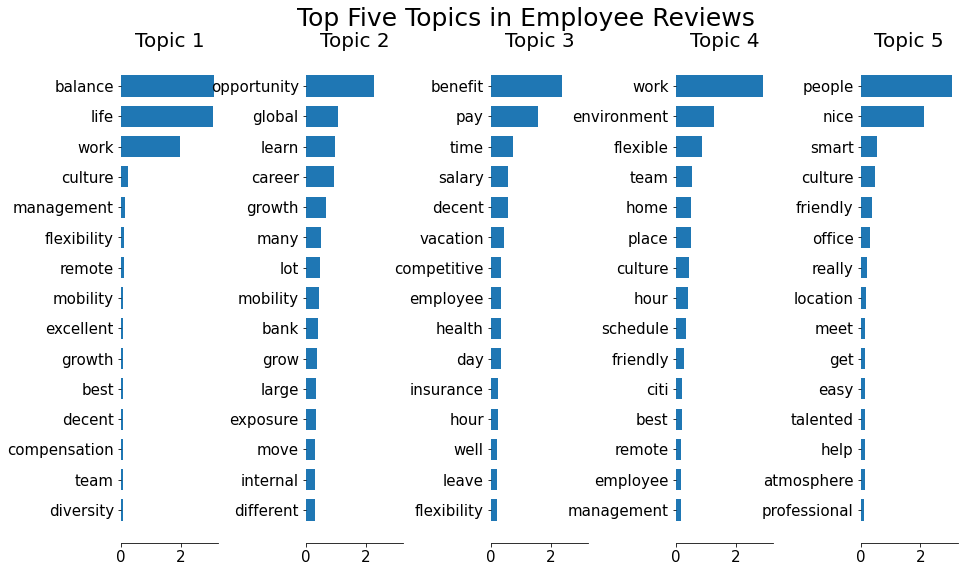

In [40]:
topic_word_plot()

In [41]:
# # feed the LDA model into the pyLDAvis instance
# vis = pyLDAvis.sklearn.prepare(topic_model, X_train, vectorizer)
# pyLDAvis.display(vis)
# pyLDAvis.save_html(vis, 'nmf_topics.html')

In [42]:
topic_name_dict = {0: 'work_life_balance', 1: 'learning_opportunities', 2: 'benefit_pay', 3: 'flexible_work_environment', 4: 'nice_smart_people'}

In [43]:
topic_keys = topic_name_dict.values()


In [44]:
H[10,:]

array([0.07169839, 0.008139  , 0.00905512, 0.02471972, 0.00052455])

In [45]:
list(zip(topic_name_dict.values(), list(H[2,:])))

[('work_life_balance', 0.0030963120352134384),
 ('learning_opportunities', 0.008905507954948268),
 ('benefit_pay', 0.07218459890753254),
 ('flexible_work_environment', 0.01696384139198502),
 ('nice_smart_people', 0.0)]

In [46]:
coefdistribution=pd.DataFrame(H, columns = topic_keys)
coefdistribution

,work_life_balance,learning_opportunities,benefit_pay,flexible_work_environment,nice_smart_people
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.003096,0.008906,0.072185,0.016964,0.000000
3,0.001500,0.000000,0.056236,0.032457,0.001165
4,0.007245,0.000000,0.000000,0.060848,0.051783
...,...,...,...,...,...
25768,0.000000,0.000000,0.000000,0.000000,0.000000
25769,0.000000,0.032971,0.007541,0.002343,0.000308
25770,0.000000,0.000000,0.000000,0.000000,0.000000
25771,0.000000,0.000000,0.000000,0.000000,0.000000


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'work_life_balance'),
  Text(1, 0, 'learning_opportunities'),
  Text(2, 0, 'benefit_pay'),
  Text(3, 0, 'flexible_work_environment'),
  Text(4, 0, 'nice_smart_people')])

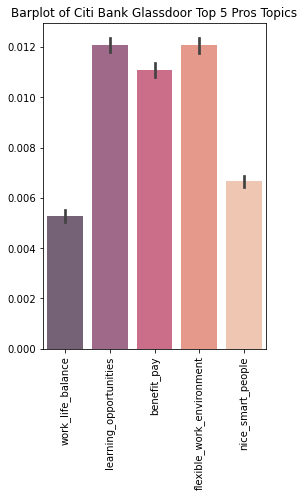

In [47]:
plt.figure(figsize=(4,6))
           
plt.title('Barplot of Citi Bank Glassdoor Top 5 Pros Topics')

sns.barplot(data=coefdistribution, palette='rocket',alpha=.7)

plt.xticks(rotation=90)

### plt.title('Barplot of Citi Bank Glassdoor Top 5 Pro Topics')

sns.barplot(data=coefdistribution,palette='crest',alpha=.8)

plt.xticks(rotation=90)

In [48]:
new_df['txtPros']

0                              [great, place, work, learn]
1                 [great, peopl, collabor, depart, except]
2        [genuin, good, compani, work, best, pay, indus...
3        [great, pay, benefit, entri, level, manag, awe...
4        [alway, peopl, work, peer, make, go, work, bet...
                               ...                        
25885               [good, premis, facil, includ, canteen]
25886                    [big, bank, option, move, around]
25887                              [experi, corpor, giant]
25888                   [holiday, work, home, good, locat]
25889                    [money, promot, co, worker, sale]
Name: txtPros, Length: 25773, dtype: object

In [49]:
from sklearn.manifold import TSNE


In [50]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

In [51]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

In [52]:
tsne_trans

,TSNE1,TSNE2,class
0,-1.078892,14.464550,work_life_balance
1,-1.348074,14.572865,work_life_balance
2,47.250820,-12.617092,benefit_pay
3,43.953857,-3.686695,benefit_pay
4,-36.017628,2.586273,flexible_work_environment
...,...,...,...
25768,-1.098476,14.469360,work_life_balance
25769,-2.382280,-48.601860,learning_opportunities
25770,-1.433375,14.622289,work_life_balance
25771,-1.769461,14.905077,work_life_balance


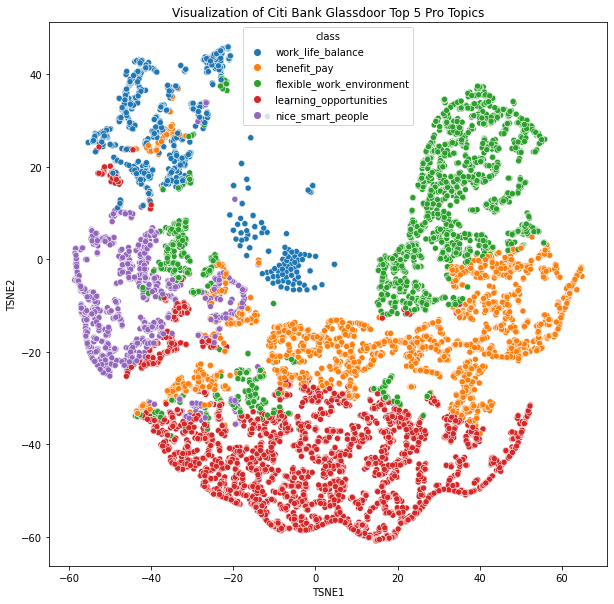

In [53]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Visualization of Citi Bank Glassdoor Top 5 Pro Topics')
plt.show()

## Feature Construction - Cons


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus_cons = new_df['Cons']
vectorizer = TfidfVectorizer()
X_train_cons = vectorizer.fit_transform(corpus_cons)
X_train_cons

<25773x10266 sparse matrix of type '<class 'numpy.float64'>'
	with 189916 stored elements in Compressed Sparse Row format>

In [55]:
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

topic_model = NMF(n_components = 5)
topic_model.fit(X_train_cons)

NMF(n_components=5)

In [56]:
H_cons = topic_model.transform(X_train_cons) # transform document into topic vector representation

# to get W 
W_cons = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W_cons.shape))
print("Shape of H is " + str(H_cons.shape))
print("Shape of X_train is " + str(X_train_cons.shape))

Shape of W is (5, 10266)
Shape of H is (25773, 5)
Shape of X_train is (25773, 10266)


In [57]:
for index,topic in enumerate(W_cons):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0
['compensation', 'personal', 'issue', 'better', 'expect', 'workload', 'challenge', 'difficult', 'team', 'heavy', 'weekend', 'overtime', 'hard', 'load', 'environment', 'need', 'much', 'improve', 'culture', 'bad', 'poor', 'pressure', 'balance', 'life', 'work']


THE TOP 10 WORDS FOR TOPIC #1
['need', 'team', 'process', 'slow', 'big', 'sometimes', 'citi', 'year', 'difficult', 'move', 'large', 'manager', 'do', 'change', 'job', 'take', 'much', 'hard', 'make', 'thing', 'work', 'many', 'people', 'time', 'get']


THE TOP 10 WORDS FOR TOPIC #2
['require', 'competitive', 'workload', 'repetitive', 'demand', 'stress', 'extra', 'overtime', 'holiday', 'pressure', 'expect', 'need', 'pay', 'week', 'stressful', 'day', 'environment', 'high', 'weekend', 'sometimes', 'time', 'working', 'work', 'long', 'hour']


THE TOP 10 WORDS FOR TOPIC #3
['base', 'advancement', 'level', 'industry', 'increment', 'slow', 'competitive', 'average', 'bank', 'high', 'increase', 'raise', 'benefit

In [58]:
%%capture topic_word_plot
def plot_top_words(W_cons, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W_cons):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W_cons, tfidf_feature_names, n_top_words, "Topics in Citi Review for Cons")

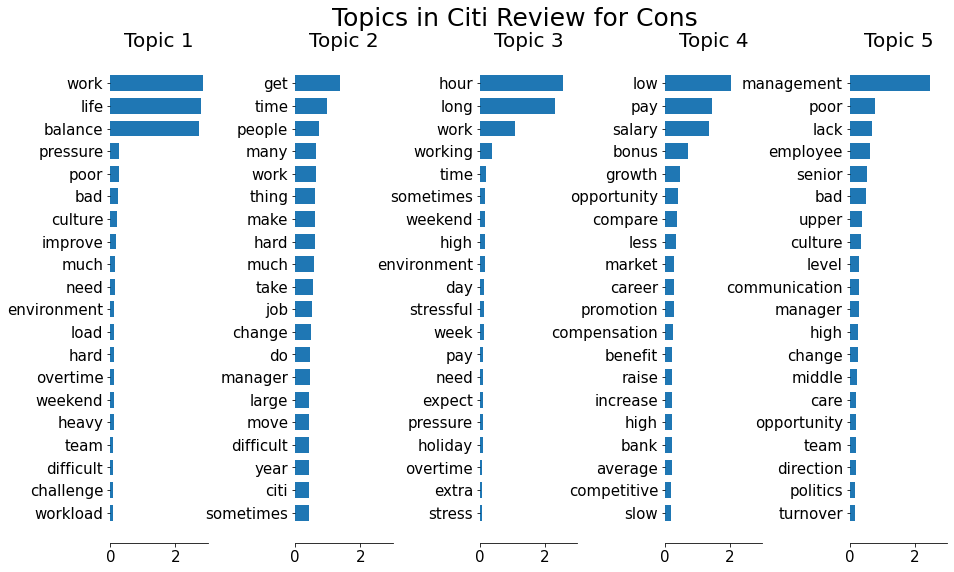

In [59]:
topic_word_plot()

In [264]:
topic_name_dict_cons = {0: 'work_pressure', 1: 'tight_deadline', 2: 'long_work_hours', 3: 'low_bonus_salary', 4: 'poor_management'}

In [265]:
topic_keys_cons = topic_name_dict_cons.values()
coefdistribution_cons=pd.DataFrame(H_cons, columns = topic_keys_cons)
coefdistribution_cons

,work_pressure,tight_deadline,long_work_hours,low_bonus_salary,poor_management
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.033064,0.000000,0.000000,0.000271
2,0.019031,0.071538,0.010560,0.009381,0.019823
3,0.000000,0.032071,0.000000,0.058019,0.000265
4,0.009271,0.013658,0.005306,0.040253,0.015835
...,...,...,...,...,...
25768,0.000000,0.000000,0.000000,0.000000,0.000000
25769,0.000000,0.000000,0.000000,0.000000,0.000000
25770,0.000000,0.007313,0.000000,0.088875,0.000000
25771,0.000000,0.000000,0.000000,0.000000,0.000000


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'work_pressure'),
  Text(1, 0, 'tight_deadline'),
  Text(2, 0, 'long_work_hours'),
  Text(3, 0, 'low_bonus_salary'),
  Text(4, 0, 'poor_management')])

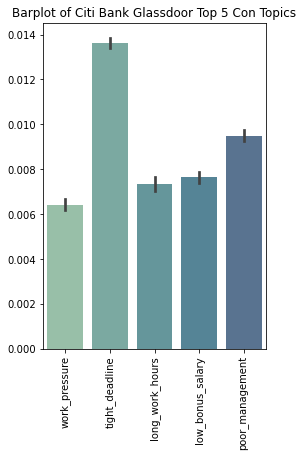

In [266]:
plt.figure(figsize=(4,6))


plt.title('Barplot of Citi Bank Glassdoor Top 5 Con Topics')

sns.barplot(data=coefdistribution_cons, palette='crest',alpha=.8)

plt.xticks(rotation=90)

In [63]:
# def review_breakdown(locator):

#     int_index = new_df.index.get_loc(locator)

#     topic_keys = topic_name_dict.values()
#     zipped_tuple = list(zip(topic_keys, list(H[int_index,:])))

#     topic_breakdown = pd.DataFrame(zipped_tuple, columns = ['Topic', 'Weight']).set_index(['Topic'])
#     topic_breakdown['Normalized weight'] = topic_breakdown['Weight']/topic_breakdown['Weight'].sum()

#     sns.barplot(y = topic_breakdown.index, x = 'Normalized weight', data = topic_breakdown)
#     plt.title("Distribution of topics for tweet no. " + str(locator))
#     plt.show()

#     return topic_breakdown

## Topics Trend 5 Year - 2017 - 2022

In [64]:
trend_df=new_df.loc[new_df['Year']>2017]

In [65]:
trend_df=trend_df.sort_values(by='Year',ascending=False)

In [66]:
trend_df['Pros'] = trend_df['Pros'].apply(process_text, args = [4])
trend_df['Cons'] = trend_df['Cons'].apply(process_text, args = [4])
trend_df['Title'] = trend_df['Title'].apply(process_text, args = [4])

In [67]:
trend_df_pros = trend_df[trend_df['Pros'] != '']
trend_df_cons =trend_df[trend_df['Cons'] != '']
trend_df_title=trend_df[trend_df['Title'] != '']

In [68]:
years=trend_df['Year'].unique()
years

array([2023, 2022, 2021, 2020, 2019, 2018])

In [69]:
def keyword_year(year):
    yeardata=trend_df.loc[trend_df['Year']==year]
    corpus = yeardata['Pros']
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(corpus)
    
    topic_model = NMF(n_components =5)
    topic_model.fit(X_train)
        
    H = topic_model.transform(X_train) # transform document into topic vector representation

    W = topic_model.components_ # word component weights for each topic
    
    for index,topic in enumerate(W):
        featurenames=[vectorizer.get_feature_names()[i] for i in topic.argsort()[-5:]]
        print(f'For year {year}, the top 3 words for topic #{index}: ',featurenames)

    return 

In [70]:
prokeyword=[keyword_year(y) for y in years]

For year 2023, the top 3 words for topic #0:  ['employee', 'growth', 'work', 'life', 'balance']
For year 2023, the top 3 words for topic #1:  ['research', 'many', 'global', 'learn', 'opportunity']
For year 2023, the top 3 words for topic #2:  ['hybrid', 'hour', 'team', 'flexible', 'work']
For year 2023, the top 3 words for topic #3:  ['gd', 'medical', 'especially', 'management', 'benefit']
For year 2023, the top 3 words for topic #4:  ['international', 'professional', 'work', 'people', 'environment']
For year 2022, the top 3 words for topic #0:  ['flexibility', 'team', 'work', 'balance', 'life']
For year 2022, the top 3 words for topic #1:  ['time', 'salary', 'decent', 'pay', 'benefit']
For year 2022, the top 3 words for topic #2:  ['place', 'environment', 'flexible', 'culture', 'work']
For year 2022, the top 3 words for topic #3:  ['global', 'learn', 'growth', 'career', 'opportunity']
For year 2022, the top 3 words for topic #4:  ['environment', 'office', 'salary', 'nice', 'people']
F

In [71]:
def keyword_year(year):
    yeardata=trend_df.loc[trend_df['Year']==year]
    corpus = yeardata['Cons']
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(corpus)
    
    topic_model = NMF(n_components =5)
    topic_model.fit(X_train)
        
    H = topic_model.transform(X_train) # transform document into topic vector representation

    W = topic_model.components_ # word component weights for each topic
    
    for index,topic in enumerate(W):
        featurenames=[vectorizer.get_feature_names()[i] for i in topic.argsort()[-5:]]
        print(f'For year {year}, the top 5 words for Cons #{index}: ',featurenames)

    return 

In [72]:
conkeyword=[keyword_year(y) for y in years]

For year 2023, the top 5 words for Cons #0:  ['organisation', 'heavy', 'life', 'balance', 'work']
For year 2023, the top 5 words for Cons #1:  ['peak', 'time', 'work', 'long', 'hour']
For year 2023, the top 5 words for Cons #2:  ['local', 'bonus', 'growth', 'increment', 'low']
For year 2023, the top 5 words for Cons #3:  ['questionable', 'expect', 'career', 'culture', 'bad']
For year 2023, the top 5 words for Cons #4:  ['pay', 'full', 'employee', 'get', 'time']
For year 2022, the top 5 words for Cons #0:  ['pressure', 'poor', 'work', 'balance', 'life']
For year 2022, the top 5 words for Cons #1:  ['weekend', 'environment', 'work', 'long', 'hour']
For year 2022, the top 5 words for Cons #2:  ['team', 'slow', 'work', 'time', 'get']
For year 2022, the top 5 words for Cons #3:  ['market', 'bonus', 'pay', 'salary', 'low']
For year 2022, the top 5 words for Cons #4:  ['lack', 'culture', 'bad', 'poor', 'management']
For year 2021, the top 5 words for Cons #0:  ['bad', 'pressure', 'work', 'bal

In [73]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set up figure and axes
# fig, axes = plt.subplots(nrows=7, figsize=(12, 12))

# # Empty dict to hold words that have already been plotted and their colors
# plotted_words_and_colors = {}
# # Establish color palette to pull from
# # (If you get an error message about popping from an empty list, increase this #)
# color_palette = sns.color_palette('cividis', n_colors=38)

# # Creating a plot for each year
# data_by_year = [y for _,y in trend_df.groupby('Year', sort=True, as_index=False)]

# for idx, year_df in enumerate(data_by_year):
#     # Find top 10 words in this year
#     all_words_in_year = trend_df.txtTitle.explode()
#     top_10 = all_words_in_year.value_counts()[:10]
    
#     # Select appropriate colors, reusing colors if words repeat
#     colors = []
#     for word in top_10.index:
#         if word not in plotted_words_and_colors:
#             new_color = color_palette.pop(0)
#             plotted_words_and_colors[word] = new_color
#         colors.append(plotted_words_and_colors[word])
    
#     # Select axes, plot data, set title
#     ax = axes[idx]
#     ax.bar(top_10.index, top_10.values, color=colors)
#     ax.set_title(year_df.iloc[0].Year)
    
# fig.tight_layout()

<AxesSubplot:xlabel='Year', ylabel='Rating'>

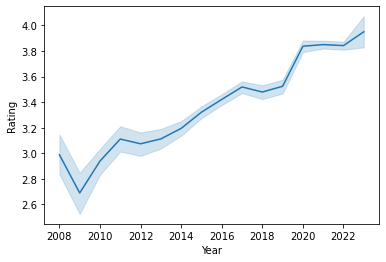

In [74]:
sns.lineplot(x=new_df['Year'],y=new_df['Rating'])

<AxesSubplot:xlabel='Year', ylabel='Count'>

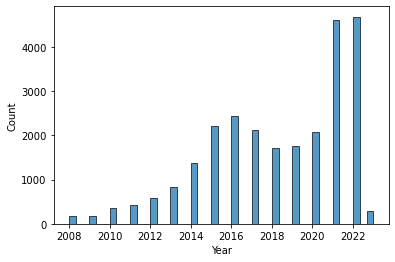

In [75]:
sns.histplot(x=new_df['Year'])

<AxesSubplot:xlabel='Rating', ylabel='count'>

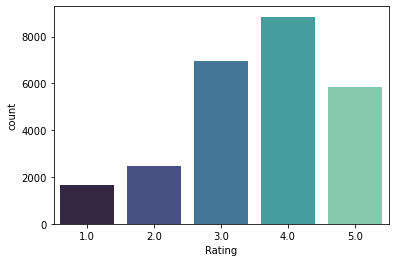

In [76]:
sns.countplot(data['Rating'],palette='mako')

In [77]:
banklevels=['Analyst','Assistant Vice President','Business Analyst','Vice President','Manager','VP','Director','Customer Service Representative','Senior Vice President','Project Manager','SVP','Managing Director','MD']

In [78]:
new_df['job_title']=new_df['job_title'].apply(lambda x : x.replace('Teller','Customer Service Representative'))

In [79]:
new_df['job_title']=new_df['job_title'].apply(lambda x : x.replace('Banker Teller','Customer Service Representative'))

In [80]:
new_df['job_title']=new_df['job_title'].apply(lambda x : x.replace('VP','Vice President'))

In [81]:
new_df['job_title']=new_df['job_title'].apply(lambda x : x.replace('AVP','Assistant Vice President'))

In [82]:
new_df['job_title']=new_df['job_title'].apply(lambda x : x.replace('Associate','Assistant Vice President'))

In [83]:
new_df['job_title']=new_df['job_title'].apply(lambda x : x.replace('AVP','Assistant Vice President'))

In [84]:
new_df['job_title']=new_df['job_title'].apply(lambda x : x.replace('Senior Analyst','Analyst'))

In [85]:
new_df['job_title']=new_df['job_title'].apply(lambda x : x.replace('Internship','Intern'))

In [86]:
new_df['job_title']=new_df['job_title'].apply(lambda x : x.replace('Bank Customer Service Representative','Customer Service Representative'))

In [87]:
titles=[x for x in new_df['job_title'].value_counts()[:20]]

In [88]:
title=new_df['job_title'].value_counts()[:20].reset_index

In [89]:
pivot = title(0)[2:]
pivot=pivot.rename(columns={"index":"Job_Title"})
pivot=pivot.drop(["job_title"],axis=1)

In [90]:
from fuzzywuzzy import fuzz, process

In [91]:
title=list([x for x in pivot['Job_Title']])

In [92]:
title=[x.strip() for x in title]

In [93]:
titbanklevels=['Analyst','Assistant Vice President','Business Analyst','Vice President','Manager','VP','Director','Customer Service Representative','Senior Vice President','Project Manager','SVP','Managing Director','MD','Assistant','Specialist','Banker','Officer','Human Resources','Developer','Accountant']


In [94]:
uniquelist=[]
threshold=80

In [95]:
new_df['cleaned_title']=new_df['job_title'].apply(lambda x:process.extractOne(x,titbanklevels,scorer=fuzz.token_set_ratio,score_cutoff=threshold)[0] if process.extractOne(x,titbanklevels,scorer=fuzz.token_set_ratio,score_cutoff=threshold)else x)




In [96]:
new_df['cleaned_title']=[x.strip() for x in new_df['cleaned_title']]

In [97]:
new_df.head()

,Title,date_job,Rating,Pros,Cons,job_title,date,txtTitle,txtPros,txtCons,Year,cleaned_title
0,,"May 8, 2022 -",5.0,,,,2022-05-08,"[great, experi, citi]","[great, place, work, learn]","[tough, deadlin, time]",2022,
1,,"Dec 11, 2022 - Vice President",5.0,,large difficult affect change meaningfully,Vice President,2022-12-11,"[solid, employ]","[great, peopl, collabor, depart, except]","[larg, compani, difficult, affect, chang, mean...",2022,Assistant Vice President
2,,"Jan 5, 2023 - Personal Banker",4.0,genuinely work best pay industry pay raise yea...,constant system issue old technology big diffe...,Personal Banker,2023-01-05,"[branch, experi]","[genuin, good, compani, work, best, pay, indus...","[constant, system, issu, old, technolog, compa...",2023,Banker
3,,"Jan 16, 2023 - Bankruptcy Specialist 3",4.0,pay benefit manager awesome work accommodate c...,raise low quite manager lead rude think good o...,Bankruptcy Specialist 3,2023-01-16,"[could, fantast, compani, work]","[great, pay, benefit, entri, level, manag, awe...","[rais, low, quit, manag, lead, rude, thought, ...",2023,Specialist
4,,"Jan 19, 2023 - Senior Trainer - Learning & Dev...",4.0,always people work peer make go work well genu...,salary transparency employee role prior pay tr...,Senior Trainer - Learning & Development,2023-01-19,"[great, compani]","[alway, peopl, work, peer, make, go, work, bet...","[salari, transpar, employe, role, prior, pay, ...",2023,Senior Trainer - Learning & Development


In [218]:
charttitles=new_df['cleaned_title'].value_counts()[:5].reset_index

In [219]:
charttitles

<bound method Series.reset_index of Analyst                     4946
Anonymous Employee          4678
Assistant Vice President    2806
                            2526
Manager                     2509
Name: cleaned_title, dtype: int64>

In [220]:
jobt= charttitles(0)
jobt

,index,cleaned_title
0,Analyst,4946
1,Anonymous Employee,4678
2,Assistant Vice President,2806
3,,2526
4,Manager,2509


In [221]:
jobt=jobt.rename(columns={"index":"cleaned_Title"})
jobt=jobt.drop(["cleaned_title"],axis=1)

In [222]:
jobt=[x for x in jobt['cleaned_Title']]

In [223]:
new_df_chart=new_df[new_df['cleaned_title'].isin(jobt)]

In [224]:
new_df_chart

,Title,date_job,Rating,Pros,Cons,job_title,date,txtTitle,txtPros,txtCons,Year,cleaned_title
0,,"May 8, 2022 -",5.0,,,,2022-05-08,"[great, experi, citi]","[great, place, work, learn]","[tough, deadlin, time]",2022,
1,,"Dec 11, 2022 - Vice President",5.0,,large difficult affect change meaningfully,Vice President,2022-12-11,"[solid, employ]","[great, peopl, collabor, depart, except]","[larg, compani, difficult, affect, chang, mean...",2022,Assistant Vice President
6,,"Jan 22, 2023 - QA Analyst",4.0,best eye plan micro manage get work home need ...,center san antonio j work outside side far drive,QA Analyst,2023-01-22,"[great, benefit]","[best, eye, plan, around, micro, manag, get, w...","[one, center, san, antonio, j, work, outsid, s...",2023,Analyst
7,,"Jan 16, 2023 - Vice President",4.0,ability learn many new thing work way many asp...,work life balance hard achieve effort make pos...,Vice President,2023-01-16,"[earn, learn]","[abil, learn, mani, new, thing, work, way, man...","[work, life, balanc, hard, achiev, effort, mak...",2023,Assistant Vice President
8,competitive pay opportunity grow location flex...,"Jan 14, 2023 - Anonymous Employee",5.0,competitive payopportunities grow hybrid remot...,bonus raise definitely lacking year economic h...,Anonymous Employee,2023-01-14,"[competit, pay, good, opportun, grow, locat, f...","[competit, pay, opportun, grow, hybrid, remot,...","[bonu, rais, definit, lack, year, despit, econ...",2023,Anonymous Employee
...,...,...,...,...,...,...,...,...,...,...,...,...
25884,,"Nov 15, 2013 -",1.0,,,,2013-11-15,[fine],"[learn, vast, area, busi]","[process, follow, care, resourc]",2013,
25885,,"May 31, 2015 - Anonymous Employee",1.0,,,Anonymous Employee,2015-05-31,[],"[good, premis, facil, includ, canteen]","[bank, big, spread]",2015,Anonymous Employee
25886,,"Feb 2, 2017 - Assistant Vice President",1.0,big bank option move around,,Assistant Vice President,2017-02-02,[avp],"[big, bank, option, move, around]","[horribl, manag, mumbai, centr]",2017,Assistant Vice President
25887,,"Apr 19, 2018 - Anonymous Employee",1.0,,low progression rate citi,Anonymous Employee,2018-04-19,[analyst],"[experi, corpor, giant]","[low, progress, rate, within, citi]",2018,Anonymous Employee


In [225]:
gb=new_df_chart.groupby(['cleaned_title','Year','Rating']).agg({'Rating':['count']}).sort_index(ascending=False)
gb=gb.reset_index()
# gb.index = gb.index.to_flat_index()

In [226]:
gb=gb.dropna()

In [262]:
gb_test = new_df_chart.groupby(['cleaned_title', 'Year', 'Rating']).count().Title.sort_index(ascending = False)
gb_test = gb_test.reset_index()
gb_test=gb_test.rename(columns = {'Title': 'Count'})

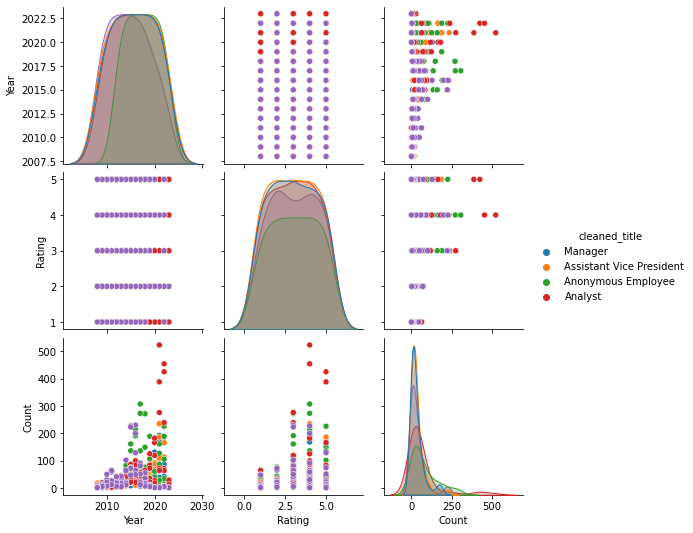

In [263]:
sns.pairplot(gb_test, hue='cleaned_title', size=2.5);


<AxesSubplot:xlabel='Year', ylabel='cleaned_title'>

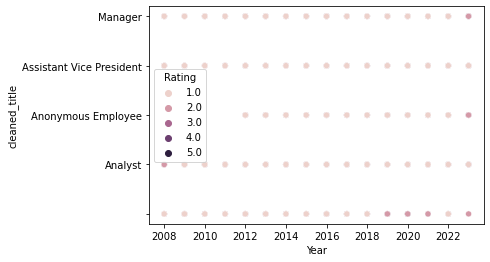

In [261]:
sns.scatterplot(data=gb_test,x='Year',y='cleaned_title',hue='Rating')